# Исследование данных

## Скачиваем датасет

In [1]:
%mkdir rzd_video
%cd rzd_video
!wget https://lodmedia.hb.bizmrg.com/case_files/1051365/train_dataset_train.zip
!unzip -q train_dataset_train.zip
%cd ..

/content/rzd_video
--2023-11-11 21:06:11--  https://lodmedia.hb.bizmrg.com/case_files/1051365/train_dataset_train.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 95.163.53.117
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839402160 (801M) [application/zip]
Saving to: ‘train_dataset_train.zip’

train_dataset_train 100%[===================>] 800.52M  22.3MB/s    in 39s     

2023-11-11 21:06:52 (20.5 MB/s) - ‘train_dataset_train.zip’ saved [839402160/839402160]

/content


## Импортируем библиотеки

In [2]:
import numpy as np
import cv2
import os
import torch

from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


SEED = 42
input_size = 224
CLASSES = dict([(i, cl) for i, cl in enumerate(sorted(os.listdir('rzd_video/videos')))])
DATA_DIR = 'rzd_video/videos'

In [3]:
CLASSES

{0: 'cartwheel',
 1: 'catch',
 2: 'clap',
 3: 'climb',
 4: 'dive',
 5: 'draw_sword',
 6: 'dribble',
 7: 'fencing',
 8: 'flic_flac',
 9: 'golf',
 10: 'handstand',
 11: 'hit',
 12: 'jump',
 13: 'pick',
 14: 'pour',
 15: 'pullup',
 16: 'push',
 17: 'pushup',
 18: 'shoot_ball',
 19: 'sit',
 20: 'situp',
 21: 'swing_baseball',
 22: 'sword_exercise',
 23: 'throw'}

## Проверяем баланс классов

In [4]:
class_count = {cls: len(os.listdir(os.path.join(DATA_DIR, cls))) for _, cls in CLASSES.items()}
class_count

{'cartwheel': 107,
 'catch': 102,
 'clap': 130,
 'climb': 108,
 'dive': 127,
 'draw_sword': 103,
 'dribble': 145,
 'fencing': 116,
 'flic_flac': 107,
 'golf': 105,
 'handstand': 113,
 'hit': 127,
 'jump': 151,
 'pick': 106,
 'pour': 106,
 'pullup': 104,
 'push': 116,
 'pushup': 103,
 'shoot_ball': 131,
 'sit': 142,
 'situp': 105,
 'swing_baseball': 143,
 'sword_exercise': 127,
 'throw': 102}

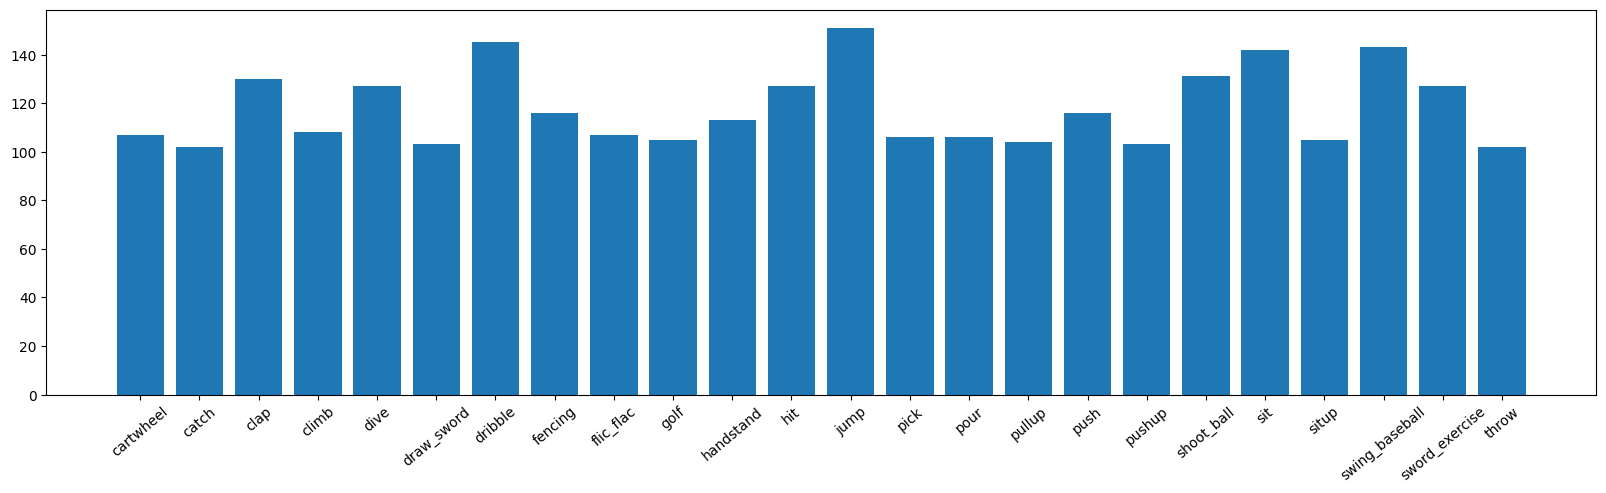

In [5]:
plt.figure(figsize=(20, 5))
plt.bar(class_count.keys(), class_count.values())
plt.xticks(rotation=40)
plt.show()

Вывод: в целом, классы сбалансированы

## Изучаем примеры видео

In [25]:
def read_video(path, enable_pil=True, frames_num=8):
    frames = []
    cap = cv2.VideoCapture(path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length//(frames_num)
    assert N > 0, 'Too many frames requested'
    current_frame = 0
    for i in range(length):
        ret, frame = cap.read(current_frame)
        if ret and i == current_frame and len(frames) < frames_num:
            if enable_pil:
                frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                frame.thumbnail((224, 224))
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            current_frame += N
    cap.release()
    return frames

In [26]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Посмотрим на кадры из случайного видео

Thumbnail for rzd_video/videos/golf/Golf_Swing_#6Iron_golf_f_cm_np1_ri_med_5.avi


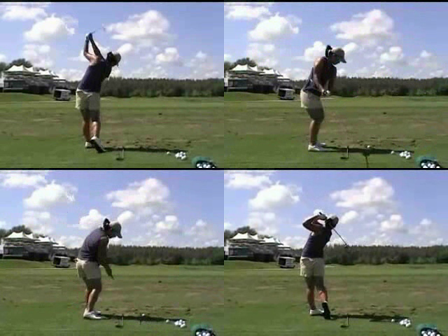

In [27]:
video_paths = {cls: os.listdir(os.path.join(DATA_DIR, cls)) for _, cls in CLASSES.items()}
cls = 'golf'
vid_path = os.path.join(DATA_DIR, cls, np.random.choice(video_paths[cls]))
imgs = read_video(vid_path, frames_num=4)
grid = image_grid(imgs, 2, 2)
print('Thumbnail for', vid_path)
grid

In [ ]:
video_paths

## Средний размер видео в пикселях

In [28]:
import random
from glob import glob

all_videos = []
for _, cls in CLASSES.items():
    all_videos.extend(glob(os.path.join(DATA_DIR, cls) + '/*'))
random.sample(all_videos, 5)

['rzd_video/videos/swing_baseball/Faith_Rewarded_swing_baseball_f_nm_np1_ba_bad_50.avi',
 'rzd_video/videos/fencing/Scaramouche__1952_fencing_u_cm_np2_fr_goo_1.avi',
 'rzd_video/videos/pick/RushHour2_pick_u_nm_np1_le_med_7.avi',
 'rzd_video/videos/draw_sword/Kendo_draw_sword_f_nm_np1_fr_bad_8.avi',
 'rzd_video/videos/pick/NH-__Open_Carry_Litter_Pickup_in__troubled__neighborhood_pick_f_nm_np1_le_med_0.avi']

In [31]:
shapes = []
for filename in random.sample(all_videos, 50):
    shapes.append(read_video(filename, enable_pil=False)[0].shape)
np.mean(shapes, axis=0)

array([240.  , 333.52,   3.  ])

## Поиск дубликатов

In [38]:
sorted(os.listdir(os.path.join(DATA_DIR, 'flic_flac')))[:50]

['17flaks_flic_flac_f_cm_np1_fr_med_0.avi',
 '17flaks_flic_flac_f_cm_np1_fr_med_1.avi',
 '17flaks_flic_flac_f_cm_np1_fr_med_2.avi',
 '6_Flick_Flacks_flic_flac_f_cm_np1_ri_med_0.avi',
 '6_Flick_Flacks_flic_flac_f_cm_np1_ri_med_1.avi',
 '6_Flick_Flacks_flic_flac_f_cm_np1_ri_med_2.avi',
 '6fach_Flick_Flack_flic_flac_f_cm_np1_le_med_0.avi',
 '6fach_Flick_Flack_flic_flac_f_cm_np1_le_med_1.avi',
 '6fach_Flick_Flack_flic_flac_f_cm_np1_le_med_2.avi',
 '7_Flickflacks_flic_flac_f_cm_np1_le_med_0.avi',
 '7_Flickflacks_flic_flac_f_cm_np1_le_med_1.avi',
 '7_Flickflacks_flic_flac_f_cm_np1_le_med_2.avi',
 'Acrobacias_de_un_fenomeno_flic_flac_f_cm_np1_ba_bad_6.avi',
 'Acrobacias_de_un_fenomeno_flic_flac_f_cm_np1_ba_bad_7.avi',
 'Acrobacias_de_un_fenomeno_flic_flac_f_cm_np1_fr_bad_0.avi',
 'Acrobacias_de_un_fenomeno_flic_flac_f_cm_np1_fr_bad_1.avi',
 'Acrobacias_de_un_fenomeno_flic_flac_f_cm_np1_fr_bad_2.avi',
 'BHS___FlickFlack_[Tutorial]_flic_flac_f_cm_np1_le_med_0.avi',
 'Bayer__Meisterin_Teresa_Sta

In [39]:
sorted(os.listdir(os.path.join(DATA_DIR, 'catch')))[:50]

['96-_Torwarttraining_1_catch_f_cm_np1_le_bad_0.avi',
 'Ball_hochwerfen_-_Rolle_-_Ball_fangen_(Timo_3)_catch_f_cm_np1_le_goo_0.avi',
 'Ball_hochwerfen_-_Rolle_-_Ball_fangen_(Timo_3)_catch_f_cm_np1_ri_med_1.avi',
 'Ballfangen_catch_u_cm_np1_fr_goo_0.avi',
 'Ballfangen_catch_u_cm_np1_fr_goo_1.avi',
 'Ballfangen_catch_u_cm_np1_fr_goo_2.avi',
 'Behinderten_Sport_part_2_catch_f_cm_np1_fr_bad_0.avi',
 'Behinderten_Sport_part_2_catch_f_cm_np1_ri_bad_1.avi',
 'Faith_Rewarded_catch_f_cm_np1_fr_med_10.avi',
 'Fangen_und_Werfen_catch_u_nm_np1_fr_bad_0.avi',
 'Finding_Forrester_3_catch_f_nm_np2_ba_med_7.avi',
 'Finding_Forrester_3_catch_u_cm_np1_fr_goo_11.avi',
 'Florian_Fromlowitz_beim_Training_der_U_21_Nationalmannschaft_catch_f_cm_np1_ri_med_0.avi',
 'Florian_Fromlowitz_beim_Training_der_U_21_Nationalmannschaft_catch_f_cm_np1_ri_med_2.avi',
 'Florian_Fromlowitz_beim_Training_der_U_21_Nationalmannschaft_catch_f_cm_np1_ri_med_4.avi',
 'Florian_Fromlowitz_beim_Training_der_U_21_Nationalmannschaft_

## Вывод по данным

- В датасете встречается очень много дубликатов
- Нет сильного дисбаланса классов
- Средний размер видео низкий, но зато при ресайзе мы почти не потеряем информации
- Будем использовать датасет Kinetics400 в дополнение к базовому датасету для обучения